In [47]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as pyp
from sklearn import svm, datasets

def min_max(*args, margin=0):
    res = []
    for arg in args:
        res.append(arg.min() - margin)
        res.append(arg.max() + margin)
    return res

def class_plot_config(P, A, steps, mode, title=None, ax_labels=None, subs=None):
    # Inicia nova imagem    
    if (subs != None):
        rows, cols, index = subs
        pyp.subplot(rows, cols, index)
    else:
        pyp.show()    
        
    # Configura título para o gráfico e rótulos para os eixos
    if (title != None):
        pyp.title(title)
        
    if (ax_labels != None):
        pyp.xlabel(ax_labels['x'])
        pyp.ylabel(ax_labels['y'])    
    
    
    # Separa o vetor de atributos, um para cada variável
    Px, Py = P[:, 0], P[:, 1]
    # Exibe a distribuição das distâncias no gráfico
    sb.scatterplot(x=Px, y=Py, hue=A, palette='viridis_r')
    
    # Valores de min - 1 e max + 1 de cada atributo
    min_x, max_x, min_y, max_y = min_max(Px, Py, margin=1)
    # Escolhe o menor passo de preenchimento do gráfico (resolução)
    step = np.abs(min([ (max_x / min_x)/steps, (max_y / min_y)/steps ]))
    
    # Seleciona a forma de criar o meshgrid. 1=binário; 2=multiclasse
    if (mode == 1):
        mesh_x, mesh_y = np.meshgrid(np.arange(min_x, max_x, step), np.arange(min_y, max_y, step))
    else:
        graph = pyp.gca()
        (xmin, xmax), (ymin, ymax) = graph.get_xlim(), graph.get_ylim()
        mesh_x, mesh_y = np.meshgrid(np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps))
        
    # Ajusta o início e fim do gráfico para cada eixo (x,y)
    pyp.xlim(min_max(mesh_x))
    pyp.ylim(min_max(mesh_y))
    
    return (mesh_x, mesh_y)

def class_plot_2D(model, P, A, steps, title=None, ax_labels=None, subs=None):
    # Recebe a matriz que reflete as posições de cada pixel no gráfico
    mesh_x, mesh_y = class_plot_config(P, A, steps, 2, title, ax_labels, subs)

    # Vetor, True para índices de instâncias dentro da margem
    decfun = model.decision_function(P)    
    svi = np.where((2 * A - 1) * decfun <= 1)[0]
    sv = P[svi]

    # Linhas da margem
    C = model.decision_function(np.c_[mesh_x.ravel(), mesh_y.ravel()])
    C = C.reshape(mesh_x.shape)
    
    # Plota linhas da margem (-1,1) e do hiperplano (0)
    ls = ['dotted', 'solid', 'dotted']; # estilos de linha
    lv = [-1, 0, 1]
    pyp.contour(mesh_x, mesh_y, C, lv, colors='k', linestyles=ls)
    # Cria uma borda ao redor das instâncias dentro da margem
    pyp.scatter(sv[:, 0], sv[:, 1], s=100, fc='none', ec='k')
    
def multiclass_plot_2D(model, P, T, steps, title=None, ax_labels=None, subs=None):
    # Recebe a matriz que reflete as posições de cada pixel no gráfico
    mesh_x, mesh_y = class_plot_config(P, T, steps, 1, title, ax_labels, subs)
    
    # Achata as matrizes X/Y, nova matriz terá cada coluna como um eixo
    ravel_xx_yy = np.c_[mesh_x.ravel(), mesh_y.ravel()]
    
    # Classifica cada pixel do gráfico segundo o modelo treinado
    C = model.predict(X=ravel_xx_yy).reshape(mesh_x.shape)
    # Define a cor de cada pixel conforme a classificação prevista
    pyp.contourf(mesh_x, mesh_y, C, cmap='viridis_r', alpha=0.2)

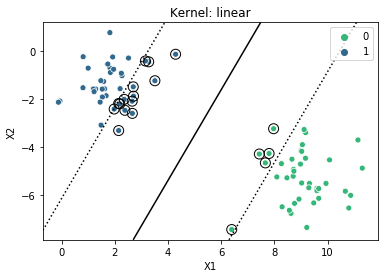

In [48]:
# Cria um conjunto de dados aleatórios. 2 Atributos previsores
X, y = datasets.make_blobs(n_samples=80, centers=2, random_state=200)
attr_names = { 'x': 'X1', 'y': 'X2' }

# Treina um SVM Linear
model = svm.LinearSVC(C=1, max_iter=10000, random_state=200)
model.fit(X, y)

# Exibe o resultado
class_plot_2D(model, X, y, 1000, 'Kernel: linear', attr_names)

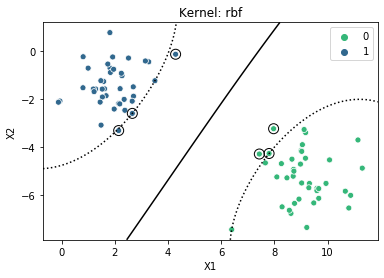

In [49]:
# Treina um SVM de Kernel RBF
model = svm.SVC(C=1, gamma='scale', kernel='rbf', max_iter=10000,
random_state=200)
model.fit(X, y)

# Exibe o resultado
class_plot_2D(model, X, y, 1000, 'Kernel: rbf', attr_names)

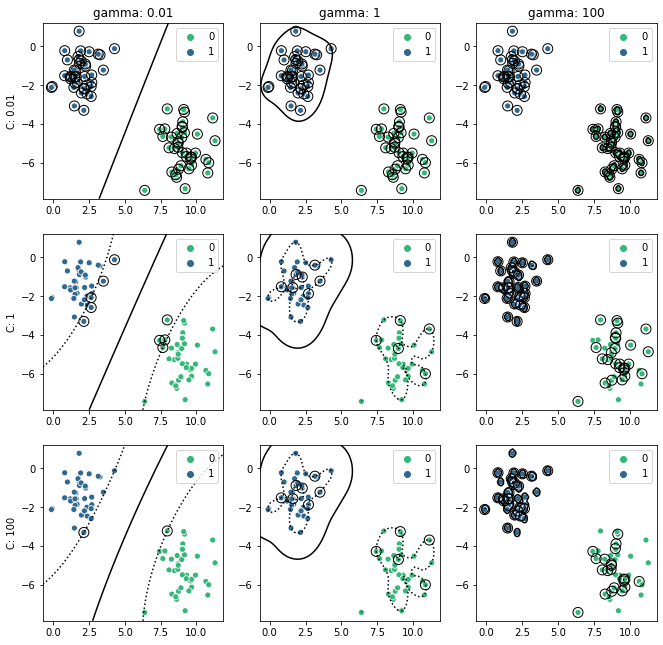

In [50]:
import itertools
C = [0.01, 1, 100]
gamma = [0.01, 1, 100]
combs = itertools.product(C, gamma)
print(combs)

# Treina um SVM de Kernel RBF
i = 0
f, axs = pyp.subplots(3,3,figsize=(11,11), sharex=True, sharey=True)
for c, g in combs:
    model = svm.SVC(C=c, gamma=g, kernel='rbf', max_iter=10000, random_state=200)
    model.fit(X, y)

    # Exibe o resultado
    title = ''
    if (i < 3):
        title = 'gamma: {0}'.format(g)
        
    class_plot_2D(model, X, y, 100, title=title, subs=(3,3,i+1))
    if (i%3 == 0):
        pyp.ylabel('C: {0}'.format(c))    
    i = i+1

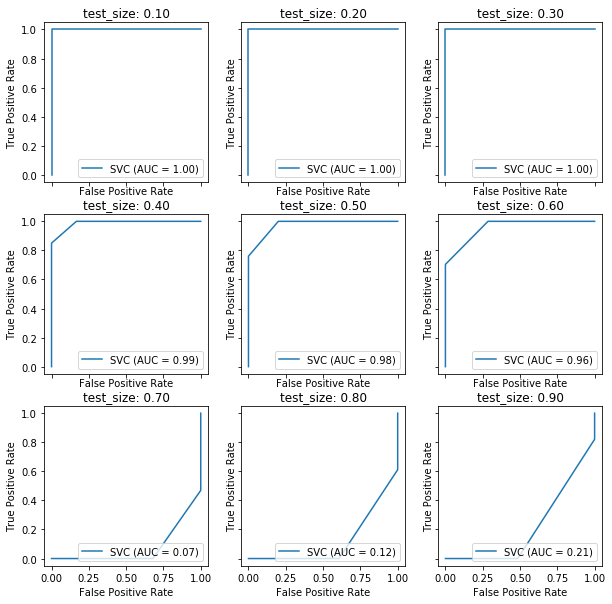

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
treinos = np.arange(0.1, 1, 0.1)

f, axes = pyp.subplots(3,3,figsize=(10,10), sharex=True, sharey=True)
axes = axes.ravel()
for i, t in enumerate(treinos):
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=t, random_state=200)
    model = svm.SVC(C=100, gamma=100, kernel='rbf', max_iter=10000, probability=True, random_state=200)
    model.fit(X_treino, y_treino)

    plot_roc_curve(estimator=model, X=X_teste, y=y_teste, ax=axes[i])
    axes[i].set_title('test_size: {0:2.2f}'.format(t))

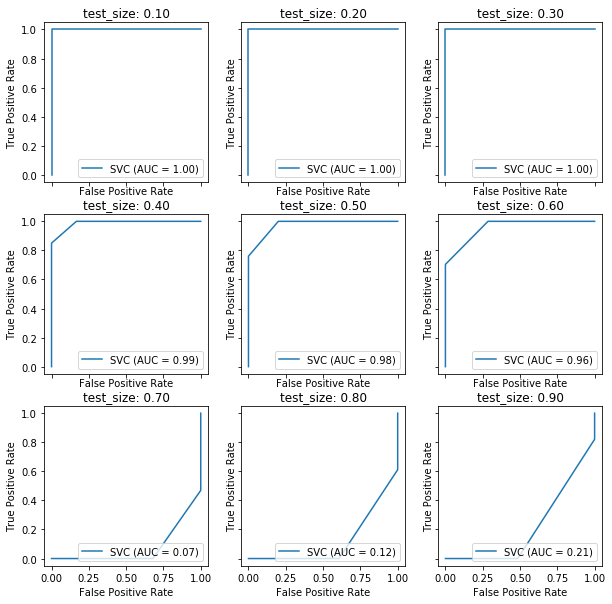

In [52]:
# duplicado????
import itertools
treinos = np.arange(0.1, 1, 0.1)
C = [0.01, 1, 100]
gamma = [0.01, 1, 100]
combs = itertools.product(C, gamma)

f, axes = pyp.subplots(3,3,figsize=(10,10), sharex=True, sharey=True)
axes = axes.ravel()
for i, t in enumerate(treinos):
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=t, random_state=200)
    model = svm.SVC(C=100, gamma=100, kernel='rbf', max_iter=10000, probability=True, random_state=200)
    model.fit(X_treino, y_treino)

    plot_roc_curve(estimator=model, X=X_teste, y=y_teste, ax=axes[i])
    axes[i].set_title('test_size: {0:2.2f}'.format(t))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


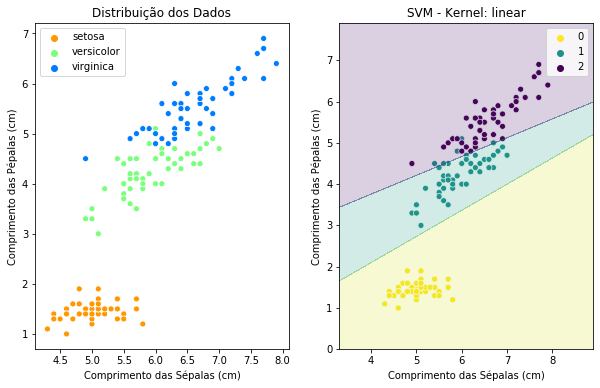

In [53]:
from sklearn import datasets as ds

# Carrega o conjunto de dados Iris
conj = ds.load_iris()

# Seleciona os Atributos de Comprimento de Sépalas/Pétalas
X = np.c_[conj['data'][:, 0], conj['data'][:, 2]]
y = conj['target']
y_named = [conj['target_names'][t] for t in y]

attr_names = {
                'x': 'Comprimento das Sépalas (cm)', 
                'y': 'Comprimento das Pépalas (cm)'
                }

# Cria um modelo de SVM linear
model = svm.LinearSVC(max_iter=10000)
# Procede com o treinamento
model.fit(X, y)

f, axes = pyp.subplots(1,2,figsize=(10,6))#, sharex=True, sharey=True)
axes = axes.ravel()
# Exibe as classificações
sb.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_named, palette='jet_r', ax=axes[0])
axes[0].set_title('Distribuição dos Dados')
axes[0].set_xlabel(attr_names['x'])
axes[0].set_ylabel(attr_names['y'])
multiclass_plot_2D(model, X, y, 1000, 'SVM - Kernel: linear', attr_names, (1,2,2))

In [59]:
from sklearn.model_selection import GridSearchCV

Cs = [1, 10, 100, 1000]
gammas = [1e-1, 1e-2, 1e-3, 1e-4]

params_list = [
                    {'kernel': ['linear'], 'C': Cs},
                    {'kernel': ['poly'], 'C': Cs, 'gamma': gammas},
                    {'kernel': ['rbf'], 'C': Cs, 'gamma': gammas}
                   ]

model = GridSearchCV(svm.SVC(probability=True, max_iter=1000000, random_state=200), params_list, scoring='roc_auc_ovr')
model.fit(X, y)

print('Melhores parâmetros: {0}\n'.format(model.best_params_))

medias = model.cv_results_['mean_test_score']
ranks = model.cv_results_['rank_test_score']
desvios = model.cv_results_['std_test_score']
params_set = model.cv_results_['params']
zipped = zip(ranks, medias, desvios, params_set)
sorted_zip = sorted(zipped, key=lambda x: x[0])
for rank, media, desvio, params in sorted_zip:
    print('Ranking: {0:0.4f} - Média: {1:0.04f} - Desvio: {2:0.04f} - Parâmetros {3}'.format(rank, media, desvio, params))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Melhores parâmetros: {'C': 10, 'kernel': 'linear'}

Ranking: 1.0000 - Média: 0.9957 - Desvio: 0.0059 - Parâmetros {'C': 10, 'kernel': 'linear'}
Ranking: 2.0000 - Média: 0.9950 - Desvio: 0.0056 - Parâmetros {'C': 1000, 'kernel': 'linear'}
Ranking: 2.0000 - Média: 0.9950 - Desvio: 0.0071 - Parâmetros {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Ranking: 2.0000 - Média: 0.9950 - Desvio: 0.0056 - Parâmetros {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Ranking: 5.0000 - Média: 0.9947 - Desvio: 0.0057 - Parâmetros {'C': 100, 'kernel': 'linear'}
Ranking: 6.0000 - Média: 0.9943 - Desvio: 0.0047 - Parâmetros {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}
Ranking: 6.0000 - Média: 0.9943 - Desvio: 0.0047 - Parâmetros {'C': 1000, 'gamma': 0.01, 'kernel': 'poly'}
Ranking: 8.0000 - Média: 0.9943 - Desvio: 0.0055 - Parâmetros {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Ranking: 8.0000 - Média: 0.9943 - Desvio: 0.0068 - Parâmetros {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Ranking: 8.0000 - Média: 0.9943 - Desvi

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


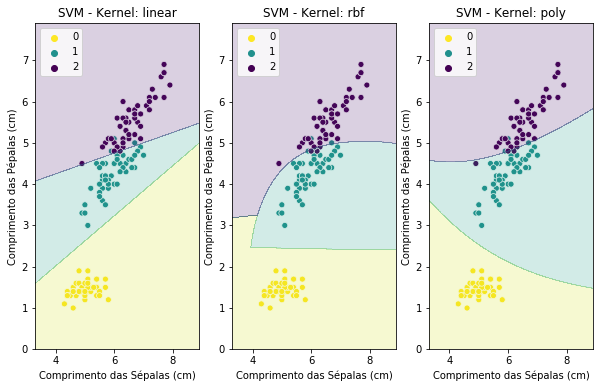

In [60]:
zip_best = sorted_zip[0][3], sorted_zip[2][3], sorted_zip[5][3]

f, axes = pyp.subplots(1,3,figsize=(10,6))#, sharex=True, sharey=True)
axes = axes.ravel()
for i, z in enumerate(zip_best):    
    zk, zc = z['kernel'], z['C']
    if (zk == 'linear'):
        modelf = svm.LinearSVC(C=zc, max_iter=100000)
    else:
        zg = z['gamma']
        modelf = svm.SVC(kernel=zk, C=zc, gamma=zg, probability=True, max_iter=100000)
    modelf.fit(X, y)
    multiclass_plot_2D(modelf, X, y, 1000, 'SVM - Kernel: {}'.format(zk), attr_names, subs=(1,3,i+1))

In [72]:
X = conj['data'][:, :2]
y = conj['target']
y_named = [conj['target_names'][t] for t in y]

attr_names = {
                'x': 'Comprimento das Sépalas (cm)', 
                'y': 'Largura das Sépalas (cm)'
                }

In [76]:
from sklearn.model_selection import GridSearchCV

Cs = [1, 10, 100, 1000]
gammas = [1e-1, 1e-2, 1e-3, 1e-4]
degrees = [0.01, 0.1, 1, 10]

params_list = [
                    {'kernel': ['linear'], 'C': Cs},
                    {'kernel': ['poly'], 'C': Cs, 'gamma': gammas, 'degree': degrees},
                    {'kernel': ['rbf'], 'C': Cs, 'gamma': gammas, 'degree': degrees}
                   ]

model = GridSearchCV(svm.SVC(probability=True, max_iter=1000000, random_state=200), params_list, scoring='roc_auc_ovr')
model.fit(X, y)

print('Melhores parâmetros: {0}\n'.format(model.best_params_))

medias = model.cv_results_['mean_test_score']
ranks = model.cv_results_['rank_test_score']
desvios = model.cv_results_['std_test_score']
params_set = model.cv_results_['params']
zipped = zip(ranks, medias, desvios, params_set)
sorted_zip = sorted(zipped, key=lambda x: x[0])
for rank, media, desvio, params in sorted_zip:
    print('Ranking: {0:0.4f} - Média: {1:0.04f} - Desvio: {2:0.04f} - Parâmetros {3}'.format(rank, media, desvio, params))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3

Melhores parâmetros: {'C': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}

Ranking: 1.0000 - Média: 0.9363 - Desvio: 0.0325 - Parâmetros {'C': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
Ranking: 1.0000 - Média: 0.9363 - Desvio: 0.0325 - Parâmetros {'C': 10, 'degree': 1, 'gamma': 0.01, 'kernel': 'poly'}
Ranking: 1.0000 - Média: 0.9363 - Desvio: 0.0325 - Parâmetros {'C': 100, 'degree': 1, 'gamma': 0.001, 'kernel': 'poly'}
Ranking: 1.0000 - Média: 0.9363 - Desvio: 0.0325 - Parâmetros {'C': 1000, 'degree': 1, 'gamma': 0.0001, 'kernel': 'poly'}
Ranking: 5.0000 - Média: 0.9357 - Desvio: 0.0333 - Parâmetros {'C': 10, 'degree': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Ranking: 5.0000 - Média: 0.9357 - Desvio: 0.0333 - Parâmetros {'C': 10, 'degree': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Ranking: 5.0000 - Média: 0.9357 - Desvio: 0.0333 - Parâmetros {'C': 10, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Ranking: 5.0000 - Média: 0.9357 - Desvio: 0.0333 - Parâmetros {'C': 10, 'degree': 10, 'gamma

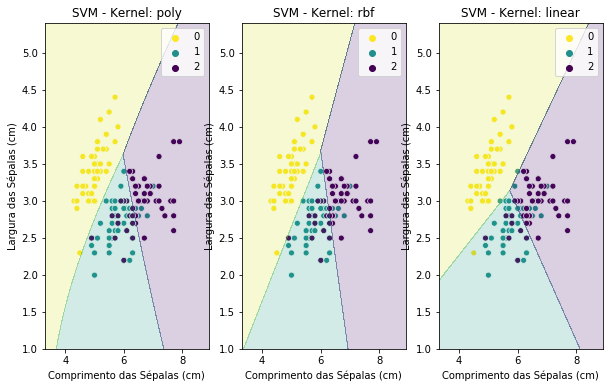

In [77]:
zip_best = sorted_zip[0][3], sorted_zip[4][3], sorted_zip[20][3]

f, axes = pyp.subplots(1,3,figsize=(10,6))#, sharex=True, sharey=True)
axes = axes.ravel()
for i, z in enumerate(zip_best):    
    zk, zc = z['kernel'], z['C']
    if (zk == 'linear'):
        modelf = svm.LinearSVC(C=zc, max_iter=100000)
    else:
        zg = z['gamma']
        modelf = svm.SVC(kernel=zk, C=zc, gamma=zg, probability=True, max_iter=100000)
    modelf.fit(X, y)
    multiclass_plot_2D(modelf, X, y, 1000, 'SVM - Kernel: {}'.format(zk), attr_names, subs=(1,3,i+1))